In [43]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import seaborn as sns
from datetime import *
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [90]:
# File path
DATA_FOLDER = "./data/"
META_HEALTH_CARE = "health_metadata.pkl"
META_SPORTS_OUTDOORS = "sports_metadata.pkl"
REVIEWS_HEALTH_CARE = "health_review.pkl"
REVIEWS_SPORTS_OUTDOORS = "sports_review.pkl"

HEALTH_CARE = "health_merge.pkl"
SPORTS_OUTDOORS = "sports_merge.pkl"

**General Analysis**

* What's the most popular categories of health and care?
* How average rating varies between different categories? Distribution of rating 
* Chronologically, how the ratings of health and care products change? And how do people rate? For some interesed category, plot the trend of rating through year
* Can we get the keywords of reviews of each year? Is there any obvious difference?

**Metadata Analysis** 
* Do people love some specific category? What's the differernce in ratings between books of different category? 
* How about the style of reviews of some specific category?  
* What's the role of price? How does price influence costumers' behaviours and books' ratings?


**Data Description**
* What's the most popular categories of health and care?
* How average rating varies between different categories? Distribution of rating 
* Chronologically, how the ratings of health and care products change? And how do people rate? For some interesed category, plot the trend of rating through year
* Price distribution(category,overall)
* Most reviewed categoried 
* Most rated categoried 
* Helpful rate

**Data Analysis**


## General Analysis

### Health Review 
#### Load data

In [3]:
df_health_review = pd.read_pickle(DATA_FOLDER+ REVIEWS_HEALTH_CARE)
df_health_review.head(8)

,asin,helpful,overall,reviewText,ReviewTime
0,0077614992,"[0, 0]",5,This book was a requirement for a college clas...,2013-02-15
1,0615208479,"[0, 0]",5,This is a great gift for anyone who wants to h...,2008-12-01
2,0615269990,"[0, 0]",5,Very helpful in learning about different disea...,2014-04-06
3,0615269990,"[1, 1]",5,Occam's Razor is an unbelievably intuitive and...,2013-12-04
4,0615269990,"[0, 0]",2,I met the guys from Nerdcore at a medical conf...,2014-04-24
5,0615315860,"[0, 0]",5,"Love this little book, Has allot of great reci...",2013-03-07
6,0615315860,"[0, 0]",5,This is a great simple book for blender bottle...,2013-01-13
7,0615406394,"[0, 0]",5,"You have to be a breast cancer survivor, which...",2013-07-07


#### Rating distribution

View the distribution of rating for the whole review data set

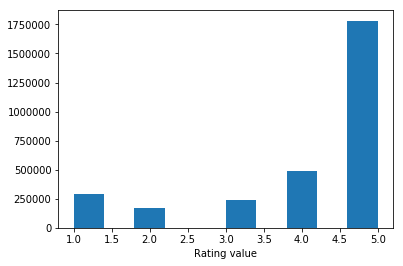

In [4]:
df_health_review.overall.hist(bins =10);
plt.grid(False)
plt.xlabel('Rating value')
plt.show()

```EXPLANATION```: Rating 5.0 is high

------

1. First, groupby column **asin(amazon id)** and aggregate the average value
2. View the distribution of average rating for dataset with uniqe id

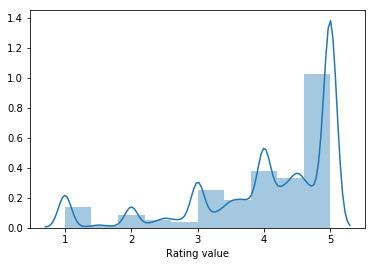

In [5]:
# ratiing average
df_rating_avg = df_health_review.groupby(df_health_review.asin)[['overall']].mean()

# rating distribution
sns.distplot(df_rating_avg,bins = 10)
plt.xlabel('Rating value')
plt.show()

```EXPLANATION```: 

#### Groupby year and get the average rating, good rating ratio,bad rating ratio

In [6]:
# Get the mean and size of rating through 2004-2014 by using groupby year 
df_rating_year_grouped = df_health_review.groupby(df_health_review.ReviewTime.dt.year)['overall']
df_rating_year = df_rating_year_grouped.agg([np.mean,np.size])

# Rename the column mean: avg
df_rating_year.rename({'mean':'avg'},axis='columns',inplace=True)

grouped = df_health_review.groupby(df_health_review.ReviewTime.dt.year)
# Calculate the ratio of Good rating(Rating value > =4)
g = grouped.apply(lambda x: (x[['overall']]>= 4).sum()/x[['overall']].count())
df_rating_year['good_rating_per'] = g['overall']

# Bad rating ratio = 1- Good rating ratio
df_rating_year['bad_rating_per'] = 1- g['overall']

# Filter the number of rating >1000
df_rating_year = df_rating_year[df_rating_year['size']>1200]
df_rating_year

,avg,size,good_rating_per,bad_rating_per
ReviewTime,,,,
2004,3.950674,2595,0.729094,0.270906
2005,3.960867,7155,0.731377,0.268623
2006,4.025686,12458,0.748676,0.251324
2007,4.123946,34757,0.777915,0.222085
2008,4.086907,49570,0.765483,0.234517
2009,4.024734,71116,0.745486,0.254514
2010,4.021525,120416,0.743331,0.256669
2011,4.029847,218313,0.744587,0.255413
2012,4.057568,407486,0.749304,0.250696


#### Average rating and the number of review though year
**Good rating **: Rating value > =4  
**Bad  rating **: Rating value < 4  
Plot the number of reviews and average rating between 2004-2014 for the whole dataset

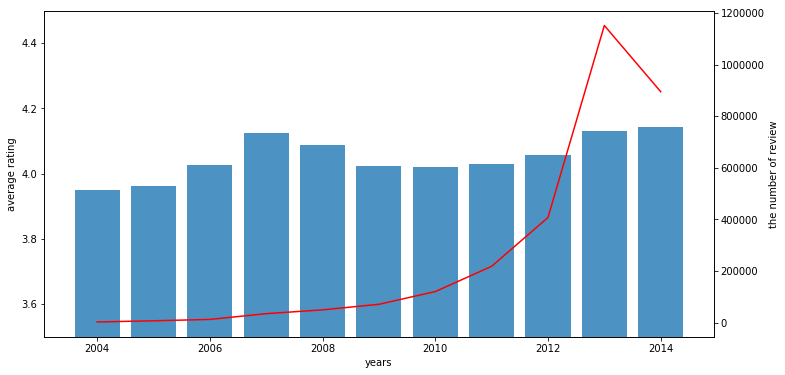

In [7]:
_, ax1 = plt.subplots(figsize = (12,6))
ax1.bar(df_rating_year.index,df_rating_year.avg, alpha=0.8)
ax1.set_ylim(3.5,4.5)
ax1.set_xlabel('years')
ax1.set_ylabel('average rating')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(df_rating_year.index,df_rating_year['size'],color ='r')
ax2.set_ylabel('the number of review')
plt.show()

#### 时间分析 xia

In [8]:
df_reviewtime_reveiwnum = df_health_review.groupby('ReviewTime').count()[['asin']]
df_reviewtime_reveiwnum.columns = ['ReviewNumber']
df_reviewtime_reveiwnum = df_reviewtime_reveiwnum.reset_index()
df_reviewtime_reveiwnum.head()

flag = df_reviewtime_reveiwnum['ReviewTime'].map(lambda x: (x.year>2006)&((x.year<2012)))

df_reviewtime_reveiwnum_subset = df_reviewtime_reveiwnum.loc[flag]
df_reviewtime_reveiwnum_subset.head()

,ReviewTime,ReviewNumber
1925,2007-01-01,21
1926,2007-01-02,35
1927,2007-01-03,470
1928,2007-01-04,261
1929,2007-01-05,150


In [9]:
def plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list):
    for i in range(3):
        plt.subplot(3,1,i + 1)
        plt.plot(df_reviewtime_reveiwnum_subset.ReviewTime, seasonal_decomposition_list[i])
        plt.xlabel('Date')
        plt.ylabel(ylabel_list[i])
        plt.title(title_list[i])
        plt.legend(['Data Change Line'])
    plt.show()

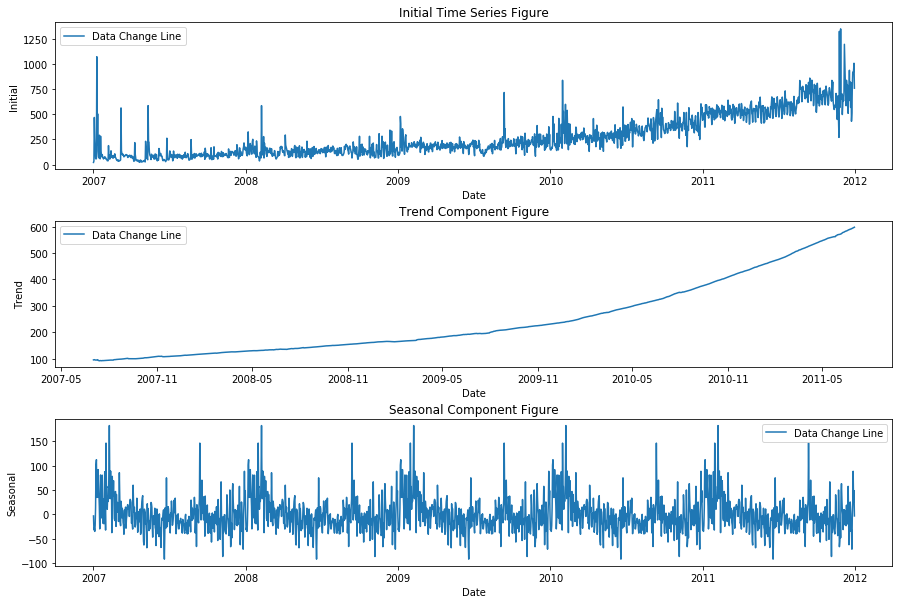

In [10]:
seasonal_decomposition = seasonal_decompose(df_reviewtime_reveiwnum_subset.ReviewNumber,freq=365)

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.35)
title_list = ['Initial Time Series Figure', 'Trend Component Figure', 'Seasonal Component Figure']
ylabel_list = ['Initial', 'Trend', 'Seasonal']

seasonal_decomposition_list = [seasonal_decomposition.observed, seasonal_decomposition.trend, 
                              seasonal_decomposition.seasonal, seasonal_decomposition.resid]

plot_seasonal_decomposition(df_reviewtime_reveiwnum_subset, seasonal_decomposition_list, title_list, ylabel_list)

#### Rating ratio though year

Plot rating scale between 2004-2014 for the whole dataset

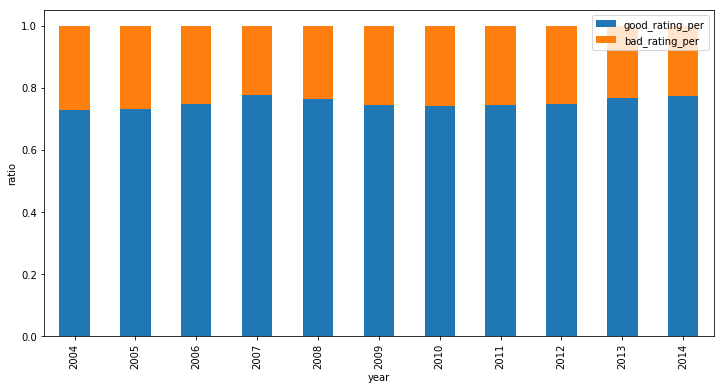

In [11]:
df_rates  = df_rating_year.iloc[:,[2,3]]
_, ax1 = plt.subplots(figsize = (12,6))
df_rates.plot.bar(stacked=True, ax=ax1)
ax1.set_xlabel('year')
ax1.set_ylabel('ratio')
plt.show()

```EXPLANATION```: 评率数量一直增加，但是好评率始终稳定保持在很高的数值 

###  Metadata

#### Brand

In [45]:
health_care_meta = pd.read_pickle(DATA_FOLDER + META_HEALTH_CARE)
sports_outdoors_meta = pd.read_pickle(DATA_FOLDER + META_SPORTS_OUTDOORS)

In [46]:
health_care_meta['brand'].isnull().value_counts()

True     138121
False    124196
Name: brand, dtype: int64

In [47]:
sports_outdoors_meta['brand'].isnull().value_counts()

True     377946
False    152043
Name: brand, dtype: int64

In [48]:
# Number of brand
len(health_care_meta['brand'].value_counts())

18512

In [49]:
# Number of brand
len(sports_outdoors_meta['brand'].value_counts())

14131

```Explantion```:brand 空集数量过于庞大 所以很bias 舍去

#### SalesRank

In [50]:
health_care_meta['salesRank'].isnull().value_counts()

False    246999
True      15318
Name: salesRank, dtype: int64

In [51]:
sports_outdoors_meta['salesRank'].isnull().value_counts()

False    484255
True      45734
Name: salesRank, dtype: int64

As we notice that in the salesrank columns, the ranks of some products don't belong to the 'Health & Personal Care' category in Health & Care data-set or 'Sports & Outdoors' in Sports & Outdoors data-set. Therefore, in this part, we want to get the counts of each category in the salerank and calculate the proportion of the categories that we're interested. We also notice that the values in the salesrank are not only typical dictionary format and 'nan' value but also many empty dictionary (which is '{}'). This type of values will be converted into 'nan'.

Main Function:
- count_abnormal()
- deal_emptydict()
- count_salerank()
- select_salerank()

In [52]:
def count_abnormal(meta_df):
    null_dict_count,notfloat_count=0,0
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        if(type(salerank).__name__=='dict'):
            if(len(salerank)==0):
    #             print("Len(salerank)==0:{s}".format(s=salerank))
                null_dict_count += 1
        elif((type(salerank).__name__!='float')):
    #         print("float type:{s},type:{t}".format(s=salerank,t=type(salerank).__name__))
            notfloat_count +=1
    print("The counts of empty dictionary: " + str(null_dict_count))
    print("The counts of figures which is not float and not dictionary: " + str(notfloat_count))

In [53]:
def deal_emptydict(meta_df):
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        if(type(salerank).__name__=='dict'):
            if(len(salerank)==0):
                meta_df['salesRank'].values[ind] = np.nan

In [54]:
def count_salerank(meta_df):
    sale_cat={}
    for ind,salerank in enumerate(meta_df['salesRank'].values):
        if (type(salerank).__name__=='float'):
            if (math.isnan(salerank)):
                if('NAN' in sale_cat):
                    sale_cat['NAN'] +=1
                else:
                    sale_cat['NAN'] = 1
            else:
                print(salerank)
                break
        elif(type(salerank).__name__=='dict'):    
            key = list(salerank.keys())[0]
            if(key in sale_cat):
                sale_cat[key] +=1
            else:
                sale_cat[key] = 1
        else:
            print(salerank)
            break
    return sale_cat

In [55]:
def select_salerank(meta_df,catname):
    rowlist=[]
    for i in range(len(meta_df)):
        if(type(meta_df.iloc[i]['salesRank']).__name__=='dict'):
            # Get key
            key = list(meta_df.iloc[i]['salesRank'].keys())[0]
            if (key ==catname):
                # find index
                idx = (meta_df.iloc[[i]]).index.values[0]
                rowlist.append(idx)
    return np.asarray(rowlist)

In [56]:
count_abnormal(health_care_meta)

The counts of empty dictionary: 470
The counts of figures which is not float and not dictionary: 0


In [60]:
deal_emptydict(health_care_meta)
count_abnormal(health_care_meta)

The counts of empty dictionary: 0
The counts of figures which is not float and not dictionary: 0


Count categories in salerank.

In [59]:
hc_countcatsale = count_salerank(health_care_meta)
hc_countcatsale

{'Arts, Crafts & Sewing': 849,
 'Automotive': 44,
 'Baby': 61,
 'Beauty': 15209,
 'Books': 1,
 'Camera &amp; Photo': 58,
 'Cell Phones & Accessories': 1,
 'Clothing': 2788,
 'Computers & Accessories': 5,
 'Electronics': 667,
 'Grocery & Gourmet Food': 96,
 'Health & Personal Care': 193734,
 'Home &amp; Kitchen': 12447,
 'Home Improvement': 252,
 'Industrial & Scientific': 4111,
 'Jewelry': 433,
 'Kitchen & Dining': 5363,
 'Movies & TV': 5,
 'Music': 15,
 'Musical Instruments': 60,
 'NAN': 15788,
 'Office Products': 61,
 'Patio, Lawn & Garden': 665,
 'Pet Supplies': 765,
 'Shoes': 689,
 'Software': 18,
 'Sports &amp; Outdoors': 6129,
 'Toys & Games': 1939,
 'Video Games': 4,
 'Watches': 60}

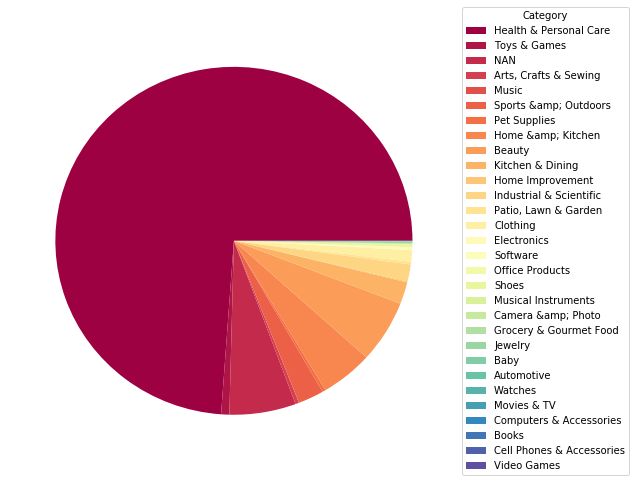

In [61]:
health_cat = list(hc_countcatsale.keys())
health_salerankcount = list(hc_countcatsale.values())

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, len(health_cat))]

fig,ax= plt.subplots(figsize=(8, 8))
wedges, texts = ax.pie(health_salerankcount,colors=colors)

ax.legend(wedges, health_cat,
          title="Category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Just have a fun

In [63]:
print("The proportion of products in the corresponding category's salerank: {p:.3f}%"
     .format(p=hc_countcatsale['Health & Personal Care']*100/len(health_care_meta)))

The proportion of products in the corresponding category's salerank: 73.855%


In [64]:
hc_row = select_salerank(health_care_meta,'Health & Personal Care')
#Check
len(hc_row)

193734

For Sports & Outdoors meta data

In [66]:
count_abnormal(sports_outdoors_meta)

The counts of empty dictionary: 305
The counts of figures which is not float and not dictionary: 0


In [67]:
deal_emptydict(sports_outdoors_meta)
count_abnormal(sports_outdoors_meta)

The counts of empty dictionary: 0
The counts of figures which is not float and not dictionary: 0


In [68]:
so_countcatsale = count_salerank(sports_outdoors_meta)
so_countcatsale

{'Arts, Crafts & Sewing': 215,
 'Automotive': 293,
 'Baby': 16,
 'Beauty': 335,
 'Books': 2,
 'Camera &amp; Photo': 456,
 'Cell Phones & Accessories': 35,
 'Clothing': 77801,
 'Computers & Accessories': 12,
 'Electronics': 665,
 'Grocery & Gourmet Food': 5,
 'Health & Personal Care': 2237,
 'Home &amp; Kitchen': 2889,
 'Home Improvement': 73,
 'Industrial & Scientific': 1222,
 'Jewelry': 1745,
 'Kitchen & Dining': 1800,
 'Movies & TV': 5,
 'Music': 13,
 'Musical Instruments': 81,
 'NAN': 46039,
 'Office Products': 6,
 'Patio, Lawn & Garden': 2728,
 'Pet Supplies': 1566,
 'Shoes': 3540,
 'Software': 27,
 'Sports &amp; Outdoors': 370418,
 'Toys & Games': 4167,
 'Video Games': 500,
 'Watches': 11098}

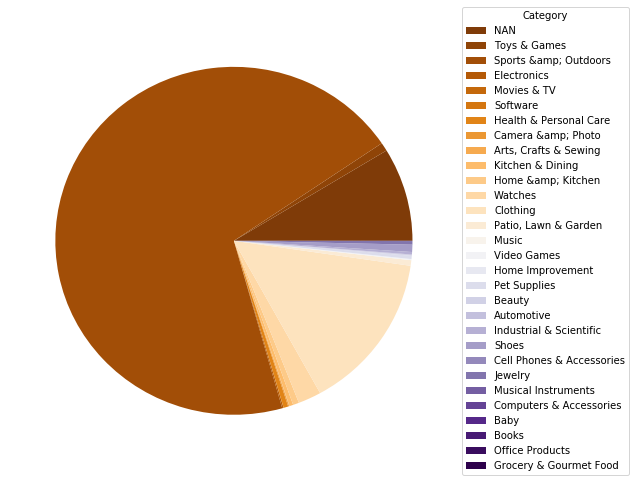

In [69]:
sports_cat = list(so_countcatsale.keys())
sports_salerankcount = list(so_countcatsale.values())

cmap = plt.get_cmap('PuOr')
colors = [cmap(i) for i in np.linspace(0, 1, len(sports_cat))]

fig,ax= plt.subplots(figsize=(8, 8))
wedges, texts = ax.pie(sports_salerankcount,colors=colors)

ax.legend(wedges, sports_cat,
          title="Category",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [70]:
so_row = select_salerank(sports_outdoors_meta,'Sports &amp; Outdoors')
#Check
len(so_row)

370418

Select row with interested category in salesrank.

In [72]:
health_valid_salerank = health_care_meta.loc[hc_row]
sports_valid_salerank = sports_outdoors_meta.loc[so_row]

###  Price

In [73]:
print("The proportion of 0 price in Health & Care is {p:.3f}%".
      format(p=len(health_care_meta[health_care_meta['price']==0])*100/len(health_care_meta)))

The proportion of 0 price in Health & Care is 25.462%


In [74]:
print("The proportion of 0 price in Health & Care is {p:.3f}%".
      format(p=len(sports_outdoors_meta[sports_outdoors_meta['price']==0])*100/len(sports_outdoors_meta)))

The proportion of 0 price in Health & Care is 46.044%


In [75]:
health_valid_price = health_care_meta[health_care_meta['price']!=0]
health_valid_price.describe()

,price
count,195526.000000
mean,28.602098
std,46.342271
min,0.010000
25%,9.250000
50%,17.000000
75%,30.980000
max,999.990000


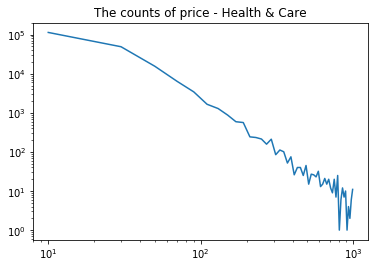

In [76]:
# health_valid_price['price'].hist(bins=50,log=True)
count_log, bin_edges =np.histogram(health_valid_price['price'],bins=50)
# middle points of bins
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.loglog(bin_centers,count_log,'-')
plt.title("The counts of price - Health & Care")
plt.show()

In [77]:
sports_valid_price = sports_outdoors_meta[sports_outdoors_meta['price']!=0]
sports_valid_price.describe()

,price
count,285963.000000
mean,50.225658
std,85.334619
min,0.010000
25%,12.950000
50%,23.990000
75%,49.950000
max,999.990000


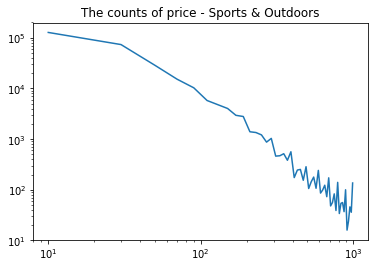

In [78]:
count_log, bin_edges =np.histogram(sports_valid_price['price'],bins=50)
# middle points of bins
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.loglog(bin_centers,count_log,'-')
plt.title("The counts of price - Sports & Outdoors")
plt.show()

From the minimum and maximum of price, we can know that the valid price in health&care and sports&outdoors both range from 0.01 to 999.99. Because we have filter the 0 value with which we replace 'nan', and there is no item with 0 price in reality, we can make an assumption that the price of original data-set just accept 0.01 to 999.99 dollars and the rest,the original 'nan' value are actually larger than 999.99 or the price has been normalized between 999.99.

###  Helpful

For Health & Care

In [81]:
health_helpszero_count = 0
for helps in df_health_review['helpful'].values:
    if (helps[1]==0):
        health_helpszero_count += 1

print("The count of 0 helpfulness voting is: " + str(health_helpszero_count))

The count of 0 helpfulness voting is: 1613817


In [83]:
print("The proportion of 0 helpfulness voting is : {p:.3f}%".format(p=health_helpszero_count*100 / len(df_health_review['helpful'].values)))

The proportion of 0 helpfulness voting is : 54.279%


For Sports & Outdoors

In [86]:
sports_helpszero_count = 0
for helps in df_sports_review['helpful'].values:
    if (helps[1]==0):
        sports_helpszero_count += 1

print("The count of 0 helpfulness voting is: " + str(sports_helpszero_count))

The count of 0 helpfulness voting is: 1950326


In [88]:
print("The proportion of 0 helpfulness voting is : {p:.3f}%".format(p=sports_helpszero_count*100 / len(df_sports_review['helpful'].values)))

The proportion of 0 helpfulness voting is : 60.165%


missing rate 太大 舍去

### Sports Review 
In this part, we do the same general analysis for Sports review dataset

#### Load data

In [12]:
df_sports_review = pd.read_pickle(DATA_FOLDER+REVIEWS_SPORTS_OUTDOORS)
df_sports_review.head()

,asin,helpful,overall,reviewText,ReviewTime
0,0000031852,"[0, 0]",4,Tutus are cute but a little thin. Can't compla...,2013-12-29
1,0000031852,"[0, 0]",4,I origonally didn't get the item I ordered. W...,2014-02-21
2,0000031852,"[0, 0]",4,"Arrived very timely, cute grandbaby loves it. ...",2014-01-14
3,0000031852,"[0, 0]",5,My little girl just loves to wear this tutu be...,2014-05-08
4,0000031852,"[0, 0]",1,I bought this for my 3 yr old daughter when I ...,2014-04-27


#### Rating distribution

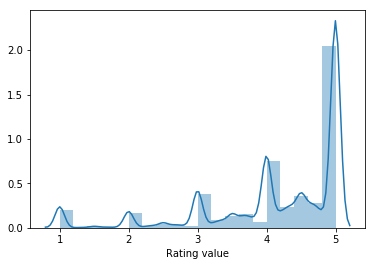

In [13]:
# ratiing average
df_rating_avg_sports = df_sports_review.groupby(df_sports_review.asin)[['overall']].mean()

# rating distribution
sns.distplot(df_rating_avg_sports,bins = 20)
plt.xlabel('Rating value')
plt.show()

#### Groupby year and get the average rating, good rating ratio,bad rating ratio

In [14]:
# rating through year
df_rating_year_grouped_sports = df_sports_review.groupby(df_sports_review.ReviewTime.dt.year)['overall']

df_rating_year_sports = df_rating_year_grouped_sports.agg([np.mean,np.size])
df_rating_year_sports.rename({'mean':'avg'},axis='columns',inplace=True)

In [15]:
grouped = df_sports_review.groupby(df_sports_review.ReviewTime.dt.year)
# Good rating >= 4.0
g = grouped.apply(lambda x: (x[['overall']]>= 4).sum()/x[['overall']].count())

df_rating_year_sports['good_rating_per'] = g['overall']
df_rating_year_sports['bad_rating_per'] = 1- g['overall']
# Filter the number of rating >1000
df_rating_year_sports = df_rating_year_sports[df_rating_year_sports['size']>1000]
df_rating_year_sports

,avg,size,good_rating_per,bad_rating_per
ReviewTime,,,,
2004,3.912715,1455,0.729210,0.270790
2005,3.808225,4693,0.692734,0.307266
2006,3.903149,11781,0.717257,0.282743
2007,4.124163,36887,0.785073,0.214927
2008,4.083802,54533,0.772743,0.227257
2009,4.071094,81568,0.766967,0.233033
2010,4.060056,134958,0.759444,0.240556
2011,4.107188,270413,0.772326,0.227674
2012,4.146070,487178,0.780101,0.219899


#### Average rating and the number of rating though year

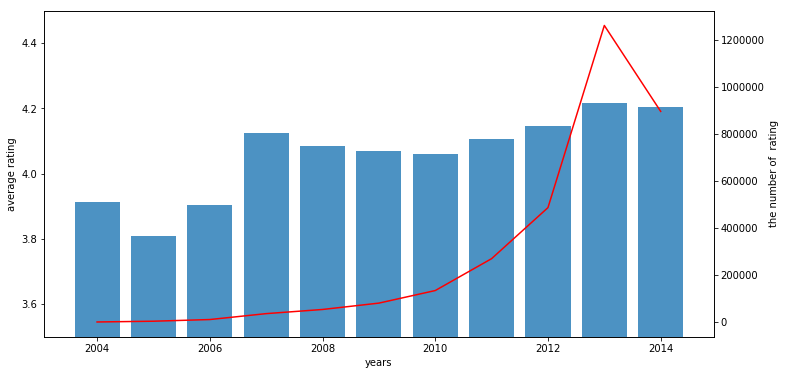

In [16]:
_, ax1 = plt.subplots(figsize = (12,6))
ax1.bar(df_rating_year_sports.index,df_rating_year_sports.avg, alpha=0.8)
ax1.set_ylim(3.5,4.5)
ax1.set_xlabel('years')
ax1.set_ylabel('average rating')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(df_rating_year_sports.index,df_rating_year_sports['size'],color ='r')
ax2.set_ylabel('the number of  rating')
plt.show()

#### Rating ratio though year

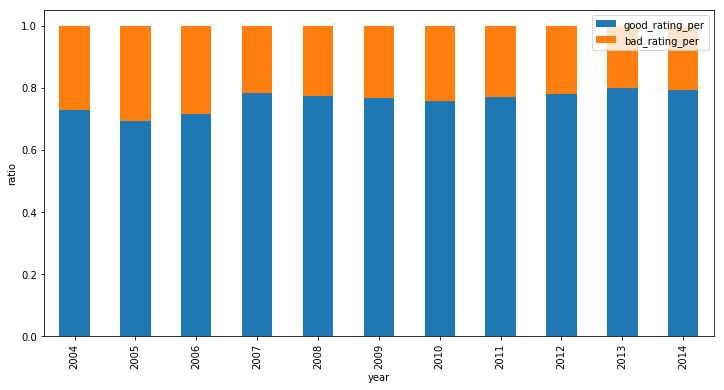

In [17]:
df_rates  = df_rating_year_sports.iloc[:,[2,3]]
_, ax1 = plt.subplots(figsize = (12,6))
df_rates.plot.bar(stacked=True,ax=ax1)
ax1.set_xlabel('year')
ax1.set_ylabel('ratio')
plt.show()

#### 时间序列

## Specific Analysis

### Health merge

#### Load the dataset

In [91]:
df_health_merge_review = pd.read_pickle(DATA_FOLDER + HEALTH_CARE)
df_health_merge_review.head(3)

,asin,helpful,overall,reviewText,ReviewTime,title,related,salesRank,categories,price,brand
0,0077614992,"[0, 0]",5,This book was a requirement for a college clas...,2013-02-15,Principles of Mgmt + Oper-CSUF Custom C,"{'also_bought': ['0471730726', '0132834871', '...",{'Health & Personal Care': 168429},[[Health & Personal Care]],0.00,NaN
1,0615208479,"[0, 0]",5,This is a great gift for anyone who wants to h...,2008-12-01,Brain Fitness Exercises Software,NaN,{'Health & Personal Care': 1346973},"[[Health & Personal Care, Personal Care]]",0.00,NaN
2,0615269990,"[0, 0]",5,Very helpful in learning about different disea...,2014-04-06,Occam's Razor,"{'also_bought': ['1935660152', '0071743979', '...",{'Toys & Games': 110575},"[[Health & Personal Care, Personal Care, Shavi...",34.99,NaN


#### Split the category into several **sub-categories**.  

For example, Split [ ['Health & Personal Care',
  'Personal Care',
  'Shaving & Hair Removal',
  'Manual Shaving'] ] into 4 class  
1st category is : 'Health & Personal Care'  
2nd category is : 'Personal Care'  
3rd category is : 'Shaving & Hair Removal'  
4th category is : 'Manual Shaving'

In [92]:
df_health_merge_review.categories[2]

[['Health & Personal Care',
  'Personal Care',
  'Shaving & Hair Removal',
  'Manual Shaving']]

In [93]:
# split the category into several sub-categories
health_cat = df_health_merge_review.categories.apply(lambda x : x[0]).values.tolist()
df_health_category = pd.DataFrame(health_cat)
df_health_category.columns = ['1st','2nd','3rd','4th','5th','6th','7th']
df_health_category.head()

,1st,2nd,3rd,4th,5th,6th,7th
0,Health & Personal Care,None,None,None,None,None,None
1,Health & Personal Care,Personal Care,None,None,None,None,None
2,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None
3,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None
4,Health & Personal Care,Personal Care,Shaving & Hair Removal,Manual Shaving,None,None,None


Since the 1st sub-categories always is ```Health & Personal Care```, we would like to analyze the 2nd sub-categories, and find the average rating and review amount though years based on this.

####  Missing rate of 2nd sub-categories

First, we calcalate the missing rate of 2nd sub-categories. If the missing rate is small we can ignore it since it will have not influnce to out analysis.

In [94]:
# None value rate 
missing_2nd = df_health_category[df_health_category.iloc[:,1].isnull()]['1st'].count()/df_health_category.shape[0]
print( 'Missing rate of 2nd sub-categories is {:.2f}%'.format(missing_2nd*100))

Missing rate of 2nd sub-categories is 2.80%


In [95]:
df_health_category['asin'] = df_health_merge_review.asin
df_health_category['overall'] = df_health_merge_review.overall
df_health_category['time'] = df_health_merge_review.ReviewTime

```Groupby``` the 2nd sub-categories and calculate the average rating and review amount

In [96]:
rating_avg = df_health_category.groupby('2nd')[['overall']].mean().sort_values('overall',ascending = False)
review_amount = df_health_category.groupby('2nd')[['overall']].count().sort_values('overall',ascending = False)

#### Average rating score for each category

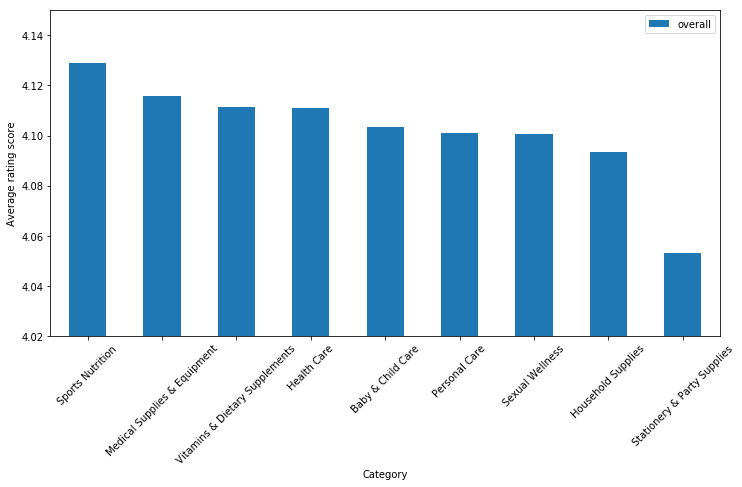

In [97]:
_, ax1 = plt.subplots(figsize = (12,6))
rating_avg.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Average rating score')
ax1.set_ylim(4.02,4.15)
plt.show()

#### Review amount for each category

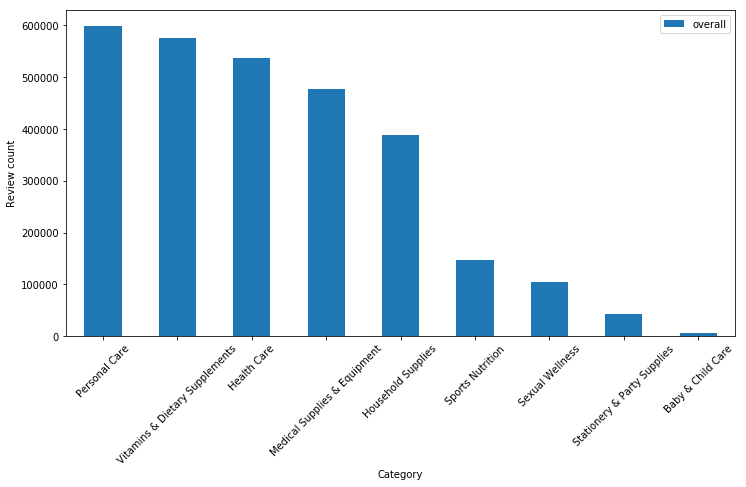

In [98]:
_, ax1 = plt.subplots(figsize = (12,6))
review_amount.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Review count')
plt.show()

#### Rating trend of interested category though years

In [99]:
def rating_average_trend(df,list_category_name):
    
    '''Input: 
       df : a dataframe
       list_category_name : A\a list of category names
       
       Output: 
       The line plot of rating trend between 2004-2014 for selected categories'''
    
    _, ax1 = plt.subplots(figsize = (12,8))
    
    for cat_name in list_category_name:
        intersted_category = df[df['2nd'] == cat_name]
        inter = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].mean()
        inter = inter.loc[inter.index>2003]
        inter.index = inter.index.astype('int')
        inter.loc[inter.index>2003].plot(ax=ax1)
    
    ax1.set_ylim(2.0,5)
    ax1.legend(list_category_name)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Average rating')
    plt.show()

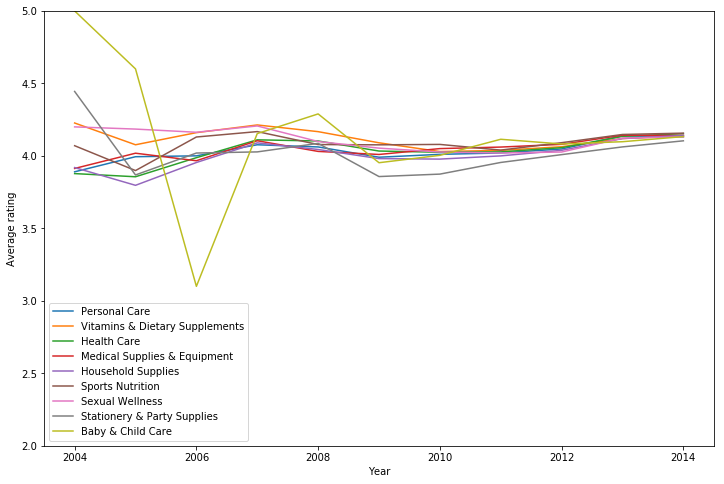

In [100]:
rating_average_trend(df_health_category,review_amount.index.values.tolist())

#### Review amount trend  of interested categories trend though years

In [102]:
def review_amount_trend(df, list_category_name):
    
    ''''Input: 
       df : a dataframe
       list_category_name : a list of category names
       
       Output: 
       The line plot of review amount trend between 2004-2014 for selected categories'''
    
    _, ax1 = plt.subplots(figsize = (12,8))
    
    for cat_name in list_category_name:
        intersted_category = df[df['2nd'] == cat_name]
        inter = intersted_category.groupby(intersted_category.time.dt.year)[['overall']].count()
        inter = inter.loc[inter.index>2003]
        inter.index = inter.index.astype('int')
        inter.loc[inter.index>2003].plot(ax=ax1)
    
    ax1.legend(list_category_name)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Review amount ')
    plt.show()

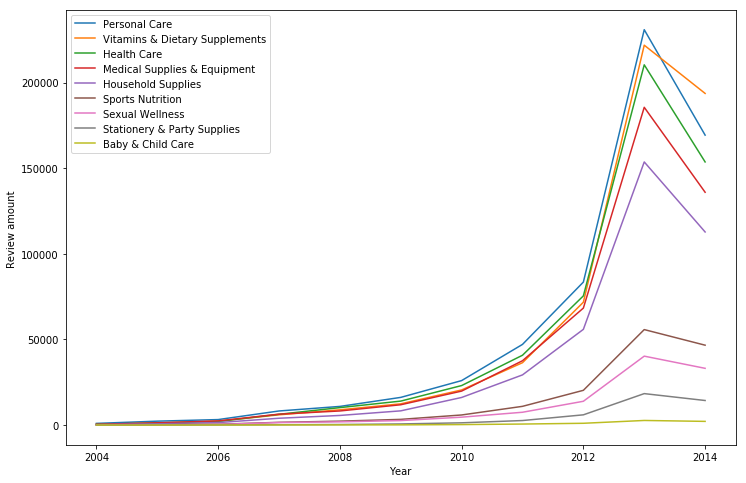

In [103]:
review_amount_trend(df_health_category,review_amount.index.values.tolist())

----------


### Sports Merge
In this part, we do the same specific analysis for Sport Merge dataset.

#### Load the dataset

In [104]:
df_sports_merge_review = pd.read_pickle(DATA_FOLDER + 'sports_merge.pkl')
df_sports_merge_review.head(3)

,asin,helpful,overall,reviewText,ReviewTime,title,price,related,brand,categories,salesRank
0,0000031852,"[0, 0]",4,Tutus are cute but a little thin. Can't compla...,2013-12-29,Girls Ballet Tutu Zebra Hot Pink,3.17,"{'also_bought': ['B00JHONN1S', 'B002BZX8Z6', '...",Coxlures,"[[Sports & Outdoors, Other Sports, Dance]]",{'Toys & Games': 211836}
1,0000031852,"[0, 0]",4,I origonally didn't get the item I ordered. W...,2014-02-21,Girls Ballet Tutu Zebra Hot Pink,3.17,"{'also_bought': ['B00JHONN1S', 'B002BZX8Z6', '...",Coxlures,"[[Sports & Outdoors, Other Sports, Dance]]",{'Toys & Games': 211836}
2,0000031852,"[0, 0]",4,"Arrived very timely, cute grandbaby loves it. ...",2014-01-14,Girls Ballet Tutu Zebra Hot Pink,3.17,"{'also_bought': ['B00JHONN1S', 'B002BZX8Z6', '...",Coxlures,"[[Sports & Outdoors, Other Sports, Dance]]",{'Toys & Games': 211836}


#### Split the category into several **sub-categories**.  

In [105]:
# split the category into several sub-categories
sports_cat = df_sports_merge_review.categories.apply(lambda x : x[0]).values.tolist()
df_sports_category = pd.DataFrame(sports_cat)
df_sports_category.columns = ['1st','2nd','3rd','4th','5th','6th','7th']
df_sports_category.head()

,1st,2nd,3rd,4th,5th,6th,7th
0,Sports & Outdoors,Other Sports,Dance,None,None,None,None
1,Sports & Outdoors,Other Sports,Dance,None,None,None,None
2,Sports & Outdoors,Other Sports,Dance,None,None,None,None
3,Sports & Outdoors,Other Sports,Dance,None,None,None,None
4,Sports & Outdoors,Other Sports,Dance,None,None,None,None


Since the 1st sub-categories always is ```Health & Personal Care```, we would like to analyze the 2nd sub-categories, and find the average rating and review amount though years based on this.

####  Missing rate of 2nd sub-categories

First, we calcalate the missing rate of 2nd sub-categories. If the missing rate is small we can ignore it since it will have not influnce to out analysis.

In [106]:
# None value rate 
missing_2nd = df_sports_category[df_sports_category.iloc[:,1].isnull()]['1st'].count()/df_sports_category.shape[0]
print( 'Missing rate of 2nd sub-categories is {:.2f}%'.format(missing_2nd*100))

Missing rate of 2nd sub-categories is 1.58%


In [107]:
df_sports_category['asin'] = df_sports_merge_review.asin
df_sports_category['overall'] = df_sports_merge_review.overall
df_sports_category['time'] = df_sports_merge_review.ReviewTime

```Groupby``` the 2nd sub-categories and calculate the average rating and review amount

In [108]:
rating_avg_sports = df_sports_category.groupby('2nd')[['overall']].mean().sort_values('overall',ascending = False)
review_amount_sports = df_sports_category.groupby('2nd')[['overall']].count().sort_values('overall',ascending = False)

#### Average rating score for each category

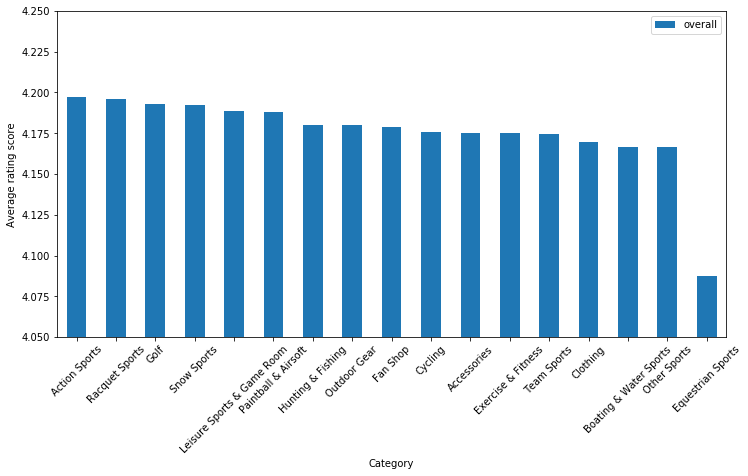

In [109]:
_, ax1 = plt.subplots(figsize = (12,6))
rating_avg_sports.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Average rating score')
ax1.set_ylim(4.05,4.25)
plt.show()

#### Review amount for each category

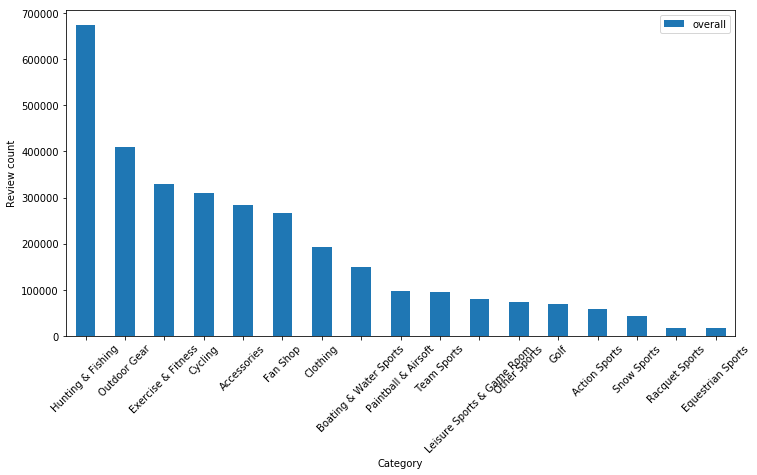

In [110]:
_, ax1 = plt.subplots(figsize = (12,6))
review_amount_sports.plot.bar(ax=ax1,rot=45)
ax1.set_xlabel('Category')
ax1.set_ylabel('Review count')
plt.show()

#### Rating trend of interested category though years

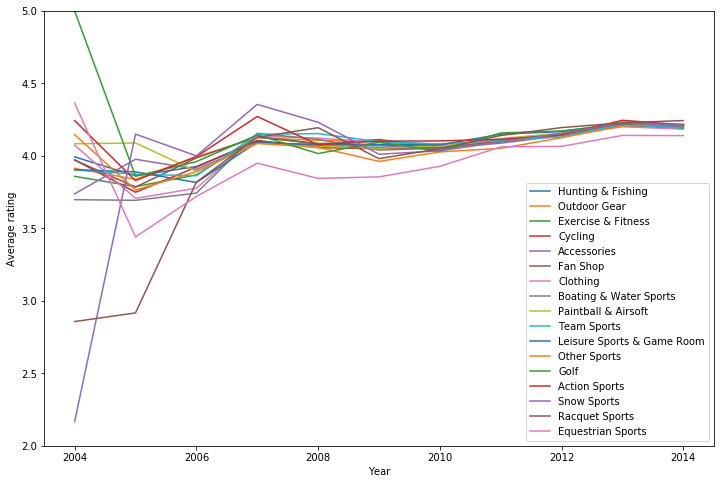

In [111]:
rating_average_trend(df_sports_category,review_amount_sports.index.values.tolist())

#### Review amount trend  of interested categories trend though years

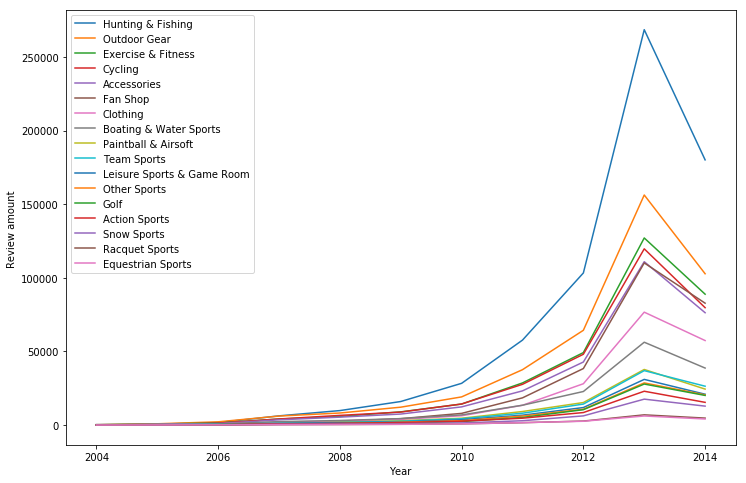

In [112]:
review_amount_trend(df_sports_category,review_amount_sports.index.values.tolist())

### Correlation analysis

In [115]:
df_health_meta = health_care_meta.copy()
df_sports_meta = sports_outdoors_meta.copy()
df_health_meta_price = df_health_meta.loc[df_health_meta['price']!=0][['price']]
df_sports_meta_price = df_sports_meta.loc[df_sports_meta['price']!=0][['price']]

In [118]:
# Merge
df_health_review_count = df_health_review.groupby('asin').count()
df_health_review_count = df_health_review_count.iloc[:, [0]]
df_health_review_count.columns = ['review_count']

df_sports_review_count = df_sports_review.groupby('asin').count()
df_sports_review_count = df_sports_review_count.iloc[:, [0]]
df_sports_review_count.columns = ['review_count']

df_health_count_price = pd.merge(df_health_meta_price, df_health_review_count, left_index=True, right_index=True)
df_sports_count_price = pd.merge(df_sports_meta_price, df_sports_review_count, left_index=True, right_index=True)

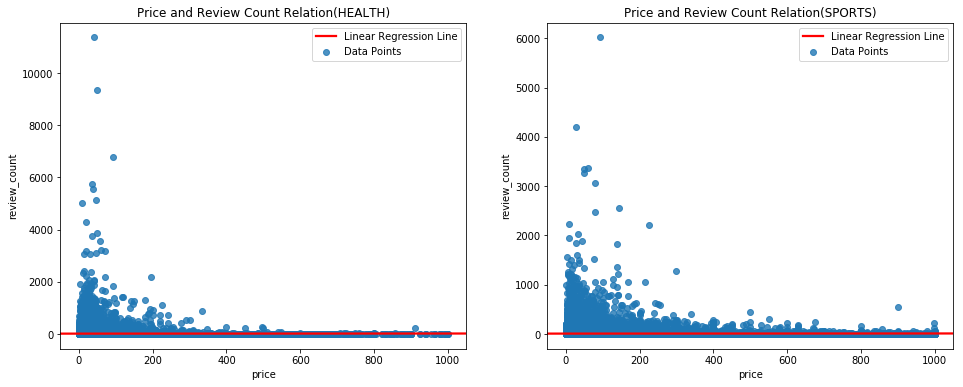

In [119]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.regplot('price', 'review_count', data=df_health_count_price, line_kws={'color':'r'})
plt.title('Price and Review Count Relation(HEALTH)')
plt.legend(('Linear Regression Line', 'Data Points'))

plt.subplot(122)
sns.regplot('price', 'review_count', data=df_sports_count_price, line_kws={'color':'r'})
plt.title('Price and Review Count Relation(SPORTS)')
plt.legend(('Linear Regression Line', 'Data Points'))

plt.show()

In [121]:
pearson_corr_health = df_health_count_price.corr()
spearman_corr_health = df_health_count_price.corr(method='spearman')
pearson_corr_sports = df_sports_count_price.corr()
spearman_corr_sports = df_sports_count_price.corr(method='spearman')
pearson_corr_health

,price,review_count
price,1.000000,0.002674
review_count,0.002674,1.000000


In [122]:
pearson_corr_health

,price,review_count
price,1.000000,0.002674
review_count,0.002674,1.000000


In [132]:
df_health_meta_salesRank_health = health_valid_salerank[['salesRank']]
df_sports_meta_salesRank_sports = sports_valid_salerank[['salesRank']] 
df_health_meta_salesRank_health = pd.DataFrame(df_health_meta_salesRank_health.salesRank.map(lambda x: x['Health & Personal Care']))
df_sports_meta_salesRank_sports = pd.DataFrame(df_sports_meta_salesRank_sports.salesRank.map(lambda x: x['Sports &amp; Outdoors']))
df_count_rank_health = pd.merge(df_health_meta_salesRank_health, df_health_review_count, left_index=True, right_index=True)
df_count_rank_sports = pd.merge(df_sports_meta_salesRank_sports, df_sports_review_count, left_index=True, right_index=True)
df_count_rank_sports.head()

,salesRank,review_count
asin,,
0188477284,338400,1
0531904822,1163159,1
059445039X,1435322,1
060791548X,306656,3
0607968699,694678,1


In [134]:
pearson_corr_health = df_count_rank_health.corr()
spearman_corr_health = df_count_rank_health.corr(method='spearman')
pearson_corr_sports = df_count_rank_sports.corr()
spearman_corr_sports = df_count_rank_sports.corr(method='spearman')
spearman_corr_health

,salesRank,review_count
salesRank,1.000000,-0.644069
review_count,-0.644069,1.000000


In [135]:
spearman_corr_sports

,salesRank,review_count
salesRank,1.000000,-0.587239
review_count,-0.587239,1.000000


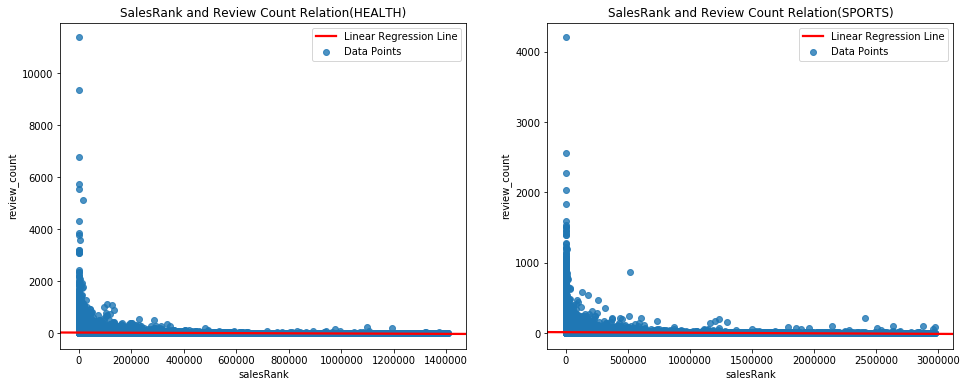

In [136]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.regplot('salesRank', 'review_count', data=df_count_rank_health, line_kws={'color':'r'})
plt.title('SalesRank and Review Count Relation(HEALTH)')
plt.legend(('Linear Regression Line', 'Data Points'))

plt.subplot(122)
sns.regplot('salesRank', 'review_count', data=df_count_rank_sports, line_kws={'color':'r'})
plt.title('SalesRank and Review Count Relation(SPORTS)')
plt.legend(('Linear Regression Line', 'Data Points'))
plt.show()